# LDpred2 Pipeline for Polygenic Risk Score Prediction

This notebook shows the pipepline for genome-wide PRS prediction using R package [bigsnpr](https://privefl.github.io/bigsnpr/) and [PLINK v1.9](https://zzz.bwh.harvard.edu/plink/) implementing the [LDpred2](https://pubmed.ncbi.nlm.nih.gov/33326037/)  method referenced on the tutorials from [Florian Privé](https://privefl.github.io/bigsnpr/articles/LDpred2.html) and [Shing Wan Choi](https://choishingwan.github.io/PRS-Tutorial/ldpred/).

*Author: Mengyu Zhang, mengyu1307@gmail.com with input from Gao Wang*

## Aim

The pipeple was developed to predict PRS using infinitesimal, grid and auto model to estimate effect size. 

## Methods

### PRS model

Typically, phenotype $Y$ for $N$ individuals is modeled as a linear combination of $M$ genetic effects, $P$ covaritates and an independent random noise shown as formula (1). 

$$
Y = \sum_{i=j}^{M} X_{j} \beta_{j} + \sum_{j=1}^{P} Z_{j} \alpha_{j} + \varepsilon \tag{1}
$$

Assuming genotype $X$ is centered and scaled, the (marginal) least-squares estimate of an individual marker effect is $\hat\beta_j=X_j^\prime Y/N$. 

[LDpred](https://pubmed.ncbi.nlm.nih.gov/26430803/) is a Bayesian PRS that account for the effects of linkage disequilibrium (LD). It estimates posterior mean causaul effect sizes from GWAS summary statistics by assuming **genetic *architecture* prior** and **LD information from a reference panel**. 

### LD reference panel

The choice of reference panel is crucial to the prediction performance of LDpred model. Population structure should ideally be the same (and in practice as similar as possible) between reference panel and training data that summary statistics are calculated from. 

Also, a [preliminary quality control](https://www.nature.com/articles/s41596-020-0353-1) on genotype reference data should be conducted. This includes but not limited to 

1. Filter individuals with much (>10%) genotype calls missing and filter SNPs that had a missing rate more than 1% and a minor allele frequency (MAF) greater than 1%
2. Remove SNPs that have ambiguous nucleotides, i.e., A/T and G/C. 

In addition to SNP filtering, [SNP flipping](http://statgen.us/lab-wiki/compbio_tutorial/allele_qc) may be necessary. It is of importance that GWAS summary stats has the same effect allele, and non-effect allele. Therefore, if the alleles of a SNP in the summary stats is the reverse of the alleles of the reference panel, the sign of z-scores (also effect size, log odds ratio, etc) is need to be flipped. At the end, summary statistics and reference panel will be matched on the basis of the SNP rsID.

Independent validation cohort or dataset can be used as LD reference panel. Here is an example in the literature: [Bjarni J. Vilhja´lmsson (2015)](https://pubmed.ncbi.nlm.nih.gov/26430803/) used 1000 Genome, Hapmap imputed cohort validation dataset as reference panel. He analyzed six large summary-statistics datasets in his study, including schizophrenia with European and non-European ancestry, multiple sclerosis (MS), breast cancer (BC), coronary crtery cisease (CAD), type II diabetes (T2D) and height. For schizophrenia with European ancestry, they used the Psychiatric Genomics Consortium 2 (PGC2) SCZ summary statistics excluding the ISC (International Schizophrenia Consortium) cohorts and the MGS (Molecular Genetics of Schizophrenia) cohorts. ISC and MGS datasets are used as validation datasets. For non-European ancestry, MGS validation datasets was used as an LD reference. To coordinate the summary statistics from Asian population, they used overlap among 1000 Genomes imputed MGS genotypes and the 1000 Genomes imputed validation genotypes for the three Asian validation datasets (JPN1, TCR1, and HOK2), respectively. For African-American (AFAM) population, they used overlap among the 1000 Genomes imputed MGS genotypes and the HapMap 3 imputed AFAM genotypes.

The reference panel applied in this pipeline is 1000 genomes project (phase 3) data including 503 (mostly unrelated) European individuals and ~1.7M SNPs in common with either HapMap3 or the UK Biobank. EUR includes Utah Residents (CEPH) with Northern and Western European Ancestry, Toscani in Italia, Finnish in Finland, British in England and Scotland and Iberian Population in Spain.

### LDpred prior effect size model

The **prior for effect sizes** is a point-normal mixture distribution, has 2 hyper-parameters: 

#### Heritability (parameter) explained by the genotypes

The heritability $h_g^2$ is estimated from LD score regression and is used as initial parameter for LDpred2 algorithm.

#### Fraction of causal markers (i.e., the fraction of markers with non-zero effects)

The distribution of effect size for variant $j$ is given as

$$
\beta_{j}  \sim\left\{\begin{array}{ll}
\mathcal{N}\left(0, \frac{h_g^{2}}{M p}\right) & \text { with probability } \mathrm{p} \\
0 & \text { otherwise }
\end{array}\right. \tag{2}
$$

#### LDpred-inf (infinitesimal model)
    
In this case, all markers are **causal** ($p$=1), and effect drawn from a Gaussian distribution, i.e., $\beta_{ij} \sim_{i i d} N\left(0,\left(h_{g}^{2} / M\right)\right)$. The posterior mean can be derived analytically

$$
E(\beta_j \mid \tilde{\beta}_j, D) \approx\left(\frac{M}{N h_{g}^{2}} I+D\right)^{-1} \tilde{\beta}_j \tag{3}
$$

where $\tilde{\beta}_{j}$ denotes a vector of marginally estimated least-squares estimates obtained from the GWAS summary statistics. $D$ denotes the LD matrix between the markers in the training data.
    
#### LDpred-grid/auto (non-infinitesimal model) 

**FIXME: please explan difference between grid and auto models**

Without considering LD, the posterior mean of effect size can be derived as 

$$
\mathrm{E}\left(\beta_{j} \mid \tilde{\beta}_{j}\right)=\left(\frac{ h_{g}^{2}}{h_{g}^{2}+\frac{M p}{N}}\right) \bar{p}_{j} \tilde{\beta}_{j} \tag{4}
$$

where $\bar p_j$ is the posterior probability that the $j^{th}$ marker is causal.

However, it is very difficult to derive a analytical expression for the posterior mean under a non-infinitesimal Gaussian mixture prior. Therefore, LDpred approximates it numerically by using an approximate MCMC Gibbs sampler. Once posterior mean effect sizes are estimated, they will be applied to genotype data to obtain **PRSs**. 

### LDpred2

LDpred2 is LDpred 2.0. It can estimate effect size without using validation data to tunning hyper-parameters. Plus, it provides better predictive performance when the causal varients in long-range LD regions and sparse.

LDpred2 algorithm relies on an assumption that 

$$
\operatorname{sd}\left(G_{j}\right) \approx \frac{\operatorname{sd}(Y)}{\operatorname{se}\left(\hat{\gamma}_{j}\right) \sqrt{n}} \tag{5}
$$

where $G_j$ the genotype vector for variant $j$, and $\hat{\gamma}_{j}$ is marginal effect of vairant $j$. For binary traits with logistic model, the approximation is 

$$
\operatorname{sd}\left(G_{j}\right) \approx \frac{2}{\operatorname{se}\left(\hat{\gamma}_{j}\right) \sqrt{n_{\mathrm{eff}}}} \tag{6}
$$

where

$$
n_{\mathrm{eff}}=\frac{4}{1 / n_{\text {case }}+1 / n_{\text {control }}} \tag{7}
$$

To ensure the validity of the assumption, quality control on summary statistics is highly recommanded: remove variants with $SD_{ss} < 0.5\times SD_{val}$ or $SD_{ss} > 0.1 + SD_{val}$ or $SD_{ss} < 0.1$ or $SD_{val} < 0.05$. $SD_{ss}$ is the standard deviations derived from the summary statistics (right-hand side of equation). $SD_{val}$ is the standard deviations of genotypes of individuals in the validation set (training set) (left-hand side).

### Other Methods for PRS Prediction

An intuitive and simple method for prediction is **unadjusted PRS**. Given linear model (1), the standard unadjusted polygenic ris score for $i^{th}$ individual is $S_i=\sum_{j=1}^MX_{ij}\hat\beta_j$ under the assumption that $X_j$ are uncorrelated.

Pruning/Clumping and thresholding (P $+$ T, C $+$ T) is a commonly used approach to preidct PRS. Variants are filterd based on an empirically determined P-value threshold. Then linked variants will be clumped into the same group. Within each group, calculate correlation among index variants and nearby variants within certain genetic distance and remove correlated nearby variants beyond a certain value. Finally, only SNPs with lowest P values in each group are selected into the prediction model.

### Method for Phenotype Prediction

Target data is splited into train dataset (80%) and test dataset (20%). Fit linear/logistic model on train dataset and then predict the phenotype on testdata. MSE and $R^2$ are calculated to considered as potential metrics to evaluate model performance of prediction. Missing genotypes are imputed with the mean of the gneotype dosage for that variant with `snp_fastImputeSimple()` according to [Florian Privé](https://github.com/privefl/bigsnpr/issues/124#issuecomment-668598849).

## Input

1. Reference panel for LD matrix (correlation) calculation `(.bed/.bim/.fam)`

    `--ref_bfile=path`
    
2. Target data: genotypes and phenotypes 

    `--test_bfile=path` `(.bed/.bim/.fam)`
    
    File contians only covariate predictors:
    
    `--cov_file=path` `(text file)`    
    
    File contrians only traits one column (phenotype):
  
    `--trait_file=path` `(text file)`
  
3. Summary statistics of base data `(.rds)`

    `--summstats_file=path`  
    
   This table should have columns: "chr", "pos", "rsid", "a1", "a0", "beta", "beta_se", "p"

## Output

The pipeline saves the results from every steps. Main outputs are

* Posterior effect size and PRS (inf/grid/auto)

    `--xxx_pred = '{outpath}/xxxPred.RData'`
    
* Regression model results for phenotype prediction

    `--xxx_model = '{outpath}/model/xxxModel.Rdata'`
    
* Summary of models and evaluation of prediction performance

    `--mod_summary = '{outpath}/summary/xxxSummary.pdf'`

* Plots
    - Quality control plot   
    - Convergence plot from grid (z socre) and auto model (heritability and proportions of causal variants)
    

## General workflow

### Step 1: Preliminary QC and selection of SNPs shared by summary statistics and target data

Filtered SNPs that had a missing rate less than 1% and a minor allele frequency (MAF) greater than 1% in the reference genotype data. Excludes individuals whoes genotype missingness rate higher than 1%.

**FIXME: please update this command based on HDL_example.ipynb**

```
sos run ldpred.ipynb extract_snp -v1 \
    --outpath <output path> \
    --testpath <target data path> \
    --ref_bed <ref.bed> \
    --test_bed <test.bed> \
    --ref_snp <ref.QC.snplist> \
    --test_snp <test.QC.snplist> \
    --summstats_file <sumstats.rds> \
    --stat_snp <sumstats.snplist>
```

## Find common SNPs and subsetting

This step returns a file `common.snplist` recording the common SNPs among reference panel, base data and target data, i.e., reference panel, summary statistics and genotypes that PRS will be derived from. Then filter variants in the reference panel and summary statistics. Common variants in target data should be filtered after SNP matching or quality control.

#### Output

* Summary statistics data after filtering common SNPs saved to `sumstats.SUB.rds`
* Reference panel after filtering common SNPs saved to `ref.SUB.bed/bim/fam`
* Common SNPs saved to three data folders saved to `outpath/common.snplist`

```
sos run ldpred.ipynb common_snp \
    --outpath <output path> \
    --testpath <target data path>
    --stat_snp <sumstats.snplist> \
    --ref_snp <ref.snplist> \
    --test_snp <test.snplist> \
    --summstats_file <sumstats.rds> \
    --sub_stats <sumstats.SUB.rds> \
    --stats_comsnp <path1/common.snplist> \
    --test_comsnp <path2/common.snplist> \
    --ref_comsnp <path3/common.snplist>
```

```
sos run ldpred.ipynb subsets \
    --outpath <output path> \
    --testpath <target data path>
    --bed_file <ref.bed> \
    --fam_file <ref.fam> \
    --snp_file <common.snplist> \
    --sub_bedfile <ref.SUB.bed>
```



## SNP Matching

Perform SNP matching using `snp_match(sumstats, map)`. Match alleles between summary statistics `sumstats` and SNP information in `map` from reference panel.

#### Output

* Integrated data `info_snp` after matching saved to `MatchedSnp.Rdata`.
* The SNPs used to fit LDpred model, also the SNPs we need to predict PRS in target data saved to `test.SUB.snplist`.

```
sos run ldpred.ipynb data_load \
    --ref_bfile <ref.SUB.bed> \
    --summstats_file <sumstats.SUB.rds> \
    --ref_file <ref.SUB.rds> \
    --test_snplist <test.SUB.snplist> \
    --outpath <output path> \ 
    --testpath <target data path>\
    --n_eff 200000 # sample size of summary statistics
```


##  Quality Control

See section 3.2. This step would greatly drop the variants, so I do not recommand do the quality control. For example, in MVP.ipynb step 4, 30376 over 30432 variants are removed. 

#### Output

* Integrated data info_snp after quality control saved to `QcMatchedSnp.Rdata`.
* Plot showing the removed SNPs save to `plots/QcPlot.png`.
* The SNPs used to fit LDpred model, also the SNPs we need to predict PRS in target data saved to `test.SUB.snplist`.


```
sos run ldpred.ipynb QControl \
    --qc_in <MatchedSnp.RData> \
    --outpath <output path> \
    --testpath <target data path>
```

## Calculate LD matrix and correlation for 22 chromosomes

Calculate LD correlation using `snp_cor(Gna, size, infos.pos)`
* size: for one SNP, window size around this SNP to compute correlations. Window size of 3 cM is applied in this pipeline which is recommanded by the developer.
* infos.pos: specifying the physical position on a chromosome (in base pairs) of each SNP. 

#### Output

* LD matrix and correlation saved to `LdMatrix.Rdata`.

```
sos run ldpred.ipynb LD \
    --outpath <output path> \
    --testpath <target data path> \
    --ld_in <MatchedSnp.Rdata/QcMatchedSnp.Rdata>
```

## Estimate posterior effect sizes and PRS

Three models can be applied to predict PRS which are infinitesimal, grid and auto models. 

* Estimate effect size 

    - Infinitesimal model: `snp_ldpred2_inf(corr, df_beta, h2)`
    - Grid model: `snp_ldpred2_grid(corr, df_beta, grid_param)`
        
        gird_param: grid of hyper parameters $p$ and $h^2$
        
    - Auto model: `snp_ldpred2_auto(corr, df_beta, h2_init, vec_p_init)`
    
        h2_init: estiamted from LD score regression
        
        vec_p_init: with 30 different initial values for p. Ranges from 0 to 0.9.
        
* Predict PRS

    For grid and auto model, the best combination of p and $h^2$ was selected based on largest t score and 3 times of median absolute deviation of predicted PRS.

Note: xxx stands for inf/grid/auto.

#### Output

* Estimated effect size `adj_beta` and PRS prediction `prs_pred` saved to `XxxPred.Rdata`.

For Inf and Auto model

```
sos run ldpred.ipynb load_testdata+<model>_prs \
    --outpath <output path> \
    --testpath <target data path> \
    --test_bfile <test.SUB.bed> \
    --<model>_in <outpath/LdMatrix.Rdata> \
    --test_file <test.SUB.rds>
```


For Grid model

```
sos run ldpred.ipynb grid_prs \
    --outpath <output path> \
    --testpath <target data path> \
    --grid_in <outpath/LdMatrix.Rdata> \
    --test_bfile <test.SUB.bed> \
    --test_file <test.SUB.rds> \
    --cov_file <covariates file> \
    --trait_file <traits file> \
    --response 1
```

## Predict phenotype

Predict phenotypes in target data and evaluate the performance of prediction using MSE and residual plots.

#### Output

* Linear/logistic model results saved to `model/XxxModel.Rdata`.
* Summary of model, goodness of fit $R^2$, MSE and residual plot saved to `summary/XxxSummary.pdf`

```
sos run ldpred.ipynb null_phenopred+<model>_phenopred \
    --outpath <output path> \
    --testpath <target data path> \
    --cov_file <covariates file> \
    --trait_file <traits file> \
    --prs_file <XxxPred.Rdata> \
    --mod_summary <Summary.pdf> \
    --model <Model.Rdata> \
    --response 1
```

# Example command

See [HDL_example.ipynb](https://github.com/cumc/bioworkflows/blob/master/ldpred/HDL_example.ipynb).

# Command Interface

In [5]:
sos run ldpred.ipynb -h

usage: sos run ldpred.ipynb [workflow_name | -t targets] [options] [workflow_options]
  workflow_name:        Single or combined workflows defined in this script
  targets:              One or more targets to generate
  options:              Single-hyphen sos parameters (see "sos run -h" for details)
  workflow_options:     Double-hyphen workflow-specific parameters

Workflows:
  extract_snp
  common_snp
  subsets
  data_load
  QControl
  LD
  load_testdata
  inf_prs
  grid_prs
  auto_prs
  null_phenopred
  inf_phenopred
  grid_phenopred
  auto_phenopred

Global Workflow Options:
  --outpath VAL (as path, required)
                        output path
  --testpath VAL (as path, required)
                        target data path

Sections
  extract_snp_10:
    Workflow Options:
      --ref-bed VAL (as path, required)
                        bedfile of ref panel and target data for QC
      --test-bed VAL (as path, required)
      --ref-snp VAL (as path, required)
                        

: 1

## Global Parameter Setting

In [ ]:
[global]
# the output directory for generated files
parameter: cwd = path
# A string to identify your analysis run
parameter: name = f"{cwd:b}"
# For cluster jobs, number commands to run per job
parameter: job_size = 1
# Wall clock time expected
parameter: walltime = "5h"
# Memory expected
parameter: mem = "16G"
# Number of threads
parameter: numThreads = 20
# use this function to edit memory string for PLINK input
from sos.utils import expand_size
cwd = path(f"{cwd:a}")

## Workflow

### Preliminary quality control and preprocessing for genotype data

In [ ]:
# Filter SNPs and select individuals 
[preprocess_1 (basic QC filters)]
# Plink binary files
parameter: genoFiles = paths
# The path to the file that contains the list of samples to remove (format FID, IID)
parameter: remove_samples = path('.')
# The path to the file that contains the list of samples to keep (format FID, IID)
parameter: keep_samples = path('.')
# The path to the file that contains the list of variants to keep
parameter: keep_variants = path('.')
# minimum MAF filter to use. Notice that PLINK default is 0.01
parameter: maf_filter = 0.01
# maximum MAF filter to use
parameter: maf_max_filter = 0.0
# Maximum missingess per-variant
parameter: geno_filter = 0.01
# Maximum missingness per-sample
parameter: mind_filter = 0.02
# HWE filter 
parameter: hwe_filter = 5e-08

fail_if(not (keep_samples.is_file() or keep_samples == path('.')), msg = f'Cannot find ``{keep_samples}``')
fail_if(not (keep_variants.is_file() or keep_variants == path('.')), msg = f'Cannot find ``{keep_variants}``')
fail_if(not (remove_samples.is_file() or remove_samples == path('.')), msg = f'Cannot find ``{remove_samples}``')

input: genoFiles, group_by=1
output: f'{cwd}/{_input:bn}.{name}{".extracted" if keep_variants.is_file() else ""}.bed'
task: trunk_workers = 1, walltime = walltime, mem = mem, cores = numThreads, tags = f'{step_name}_{_output:bn}'
bash: expand= "${ }", stderr = f'{_output:n}.stderr', stdout = f'{_output:n}.stdout'
    plink \
      --bfile ${_input:n} \
      ${('--maf %s' % maf_filter) if maf_filter > 0 else ''} \
      ${('--max-maf %s' % maf_max_filter) if maf_max_filter > 0 else ''} \
      ${('--geno %s' % geno_filter) if geno_filter >= 0 else ''} \
      ${('--hwe %s' % hwe_filter) if hwe_filter >= 0 else ''} \
      ${('--mind %s' % mind_filter) if mind_filter >= 0 else ''} \
      ${('--keep %s' % keep_samples) if keep_samples.is_file() else ""} \
      ${('--remove %s' % remove_samples) if remove_samples.is_file() else ""} \
      ${('--extract %s' % keep_variants) if keep_variants.is_file() else ""} \
      --make-bed \
      --out ${_output:n} \
      --threads ${numThreads} \
      --memory ${int(expand_size(mem) * 0.9)}

In [ ]:
[preprocess_2 (convert plink to bigsnpr format with missing data mean imputed)]
input: group_by = 1, concurrent = False
output: f"{cwd:a}/{_input:bn}.bk", f"{cwd:a}/{_input:bn}.rds"
task: trunk_workers = 1, walltime = walltime, mem = mem, cores = numThreads, tags = f'{step_name}_{_output[0]:bn}'
bash: expand = "${ }"
    rm -f ${_output}
R: expand= "${ }", stderr = f'{_output[0]:n}.stderr', stdout = f'{_output[0]:n}.stdout'
    library(bigsnpr)
    # generate .bk and .rds file for R code
    dat = snp_readBed(${_input:r}, backingfile=${_output[0]:nr})
    obj.bigSNP <- snp_attach(dat) 
    # get the CM information from 1000 Genome
    # will download the 1000G file to the current directory (".")
    obj.bigSNP$map$genetic.dist <- snp_asGeneticPos(obj.bigSNP$map$chromosome, obj.bigSNP$map$physical.pos, dir = ${cwd:r})
    obj.bigSNP$genotypes = snp_fastImputeSimple(obj.bigSNP$genotypes, method = "mean0")
    saveRDS(obj.bigSNP, file = "${_output[1]}")

## Find common SNPs among summary statistics, reference panel and test genotypes.

1. Find common SNPs
2. Get subsets.

In [ ]:
# SNP intersect of summary stats and genotype data
[snp_intersect_1]
# Plink binary files
parameter: genoFiles = paths
# summary stats file
parameter: ss = path
input: ss, [x.with_suffix(".bim") for x in genoFiles]
output: substats = f"{cwd:a}/{_input[0]:bn}.intersect.rds",
        snp = f"{cwd:a}/{_input[0]:bn}.intersect.snplist"
task: trunk_workers = 1, walltime = walltime, mem = mem, cores = numThreads, tags = f'{step_name}_{_output[0]:bn}'
R: expand= "${ }", stderr = f'{_output[0]:n}.stderr', stdout = f'{_output[0]:n}.stdout'
    suppressMessages(library(tidyverse))
    sumstats <- readRDS(${_input[0]:r})
    geno_snps = lapply(c(${paths(_input[1:]):r,}), function(x) read.table(x, stringsAsFactors=F)[,2])
    common_snp <- Reduce(intersect, c(list(sumstats$rsid), geno_snps))
    # filter snps in sumstat
    new_sumstats <- sumstats %>%
        filter(rsid %in% common_snp)
    print(paste("There are", length(common_snp), "shared SNPs."))
    saveRDS(new_sumstats, file = "${_output["substats"]}")
    write.table(common_snp, file = "${_output["snp"]}", sep = " ", 
                row.names = FALSE, col.names = FALSE, quote=FALSE)
  
[snp_intersect_2]
# Plink binary files
parameter: genoFiles = paths
output: [(f"{cwd}/{x:bn}.snp_intersect.extracted.bed", f"{cwd}/{x:bn}.snp_intersect.extracted.rds") for x in genoFiles]
sos_run("preprocess", genoFiles=genoFiles, keep_variants=_input['snp'], 
                    maf_filter=0, geno_filter=1, mind_filter=1, hwe_filter=-9, 
                    cwd=cwd, name="snp_intersect")

In [ ]:
[snp_subset]
parameter: genoObj = path
parameter: keep_variants = path
input: genoObj, keep_variants
output: f"{cwd}/{_input[0]:bn}.{name}.subset.rds"
R: expand= "${ }", stderr = f'{_output:n}.stderr', stdout = f'{_output:n}.stdout'   
    library(bigsnpr)
    dat <- readRDS("${_input[0]}")
    snps <- as.vector(unlist(data.table::fread("${_input[1]}",header=F)))
    snp_subset(dat,  ind.col = match(snps, dat$map$marker.ID), backingfile = ${_output:nr})

## Convert reference genotype to bigsnpr format and get the genetic distance cM information

Will take a while to download the genetic distance database.

## Allele harmonizing 

In [ ]:
[snp_match]
# summary stats file
parameter: ss = path
parameter: reference_geno = path
input: ss, reference_geno
output: match = f'{cwd:a}/{_input[0]:bn}.snp_matched.rds',
        snplist = f'{cwd:a}/{_input[0]:bn}.snp_matched.snplist'
task: trunk_workers = 1, walltime = walltime, mem = mem, cores = numThreads, tags = f'{step_name}_{_output[0]:bn}'
R: expand= "${ }", stderr = f'{_output[0]:n}.stderr', stdout = f'{_output[0]:n}.stdout'   
    library(bigsnpr)
    sumstats <- readRDS("${_input[0]}")
    # now attach the genotype object
    obj.bigSNP <- snp_attach("${_input[1]}")
    # extract the SNP information from the genotype
    map <- obj.bigSNP$map[-(2:3)]
    names(map) <- c("chr", "pos", "a1", "a0")  
    # perform SNP matching
    updated_ss <- snp_match(sumstats, map)
    write.table(updated_ss$rsid, file = "${_output["snplist"]}", sep = " ", 
            row.names = FALSE, col.names = FALSE,quote=FALSE)
    saveRDS(updated_ss, file = "${_output["match"]}")

## Summary statistics quality Control

In [ ]:
[sumstats_qc]
# effective sample size
parameter: n_eff = int
# summary stats file, snp matched
parameter: ss = path
# reference data geno object previously generated
parameter: reference_geno = path
input: ss, reference_geno

output: qc_plot = f'{cwd}/{_input[0]:bn}.qc.png', 
        snplist = f'{cwd}/{_input[0]:bn}.qc.snplist',
        qc_res = f'{cwd}/{_input[0]:bn}.qc.rds'

task: trunk_workers = 1, walltime = walltime, mem = mem, cores = numThreads, tags = f'{step_name}_{_output[0]:bn}'
R: expand= "${ }", stderr = f'{_output[0]:n}.stderr', stdout = f'{_output[0]:n}.stdout'
    library(bigsnpr)
    suppressMessages(library(tidyverse))
    attach(readRDS("${_input[1]}"))
    info_snp = readRDS(${_input[0]:r})
    NCORES = bigparallelr::nb_cores()
    NCORES = tryCatch({bigparallelr::assert_cores(NCORES); NCORES }, error = function(e) 1)
    ind.val = 1:nrow(genotypes)
    sd <- sqrt(big_colstats(genotypes, ind.val, ncores = NCORES)$var)
    n_eff <- ${n_eff}
  
    sd_val <- sd[info_snp$`_NUM_ID_`]

    sd_ss <- with(info_snp, 2 / sqrt(n_eff * beta_se^2))

    is_bad <- sd_ss < (0.5 * sd_val) | 
            sd_ss > (sd_val + 0.1) |
            sd_ss < 0.1 | 
            sd_val < 0.05
      
    qplot(sd_val, sd_ss, color = is_bad, alpha = I(0.5)) +
      theme_bigstatsr() +
      coord_equal() +
      scale_color_viridis_d(direction = -1) +
      geom_abline(linetype = 2, color = "red") +
      labs(x = "Standard deviations in the validation set",
           y = "Standard deviations derived from the summary statistics",
           color = "Removed?")
    ggsave("${_output["qc_plot"]}")      
      
    n = nrow(info_snp)
    print(paste(length(which(is_bad=="TRUE")), "over", n, "were removed in summary statistics QC."))
           
    info_snp = info_snp[!is_bad, ]
    
    write.table(info_snp$rsid, file = ${_output["snplist"]:r}, sep = " ", 
            row.names = FALSE, col.names = FALSE,quote=FALSE)
    saveRDS(info_snp, file=${_output["qc_res"]:r})

## Calculate LD matrix and perform LD score regression 

In [ ]:
[ldsc]
# effective sample size
parameter: n_eff = int
# summary stats file
parameter: ss = path
parameter: reference_geno = path
input: ss, reference_geno
output: f'{cwd}/{_input[0]:bn}.ld.rds'
task: trunk_workers = 1, walltime = walltime, mem = mem, cores = numThreads, tags = f'{step_name}_{_output[0]:bn}'
R: expand= "${ }", stderr = f'{_output[0]:n}.stderr', stdout = f'{_output[0]:n}.stdout'
    library(bigsnpr)
    library(data.table)
    library(bigsparser)
    suppressMessages(library(tidyverse))
    info_snp = readRDS("${_input[0]}")
    attach(readRDS("${_input[1]}"))
    NCORES = bigparallelr::nb_cores()
    NCORES = tryCatch({bigparallelr::assert_cores(NCORES); NCORES }, error = function(e) 1)
    # Initialize variables for storing the LD score and LD matrix
    corr = NULL
    ld = NULL
    # We want to know the ordering of samples in the bed file 
    fam.order = NULL
    # Open a temporary file
    tmp = tempfile(tmpdir = "${cwd}/res-data")
    on.exit(file.remove(paste0(tmp, ".sbk")), add = TRUE)
    
    for (chr in 1:22) {
      # Extract SNPs that are included in the chromosome
      ind.chr <- which(info_snp$chr == chr)
      ind.chr2 <- info_snp$`_NUM_ID_`[ind.chr]
      # Calculate the LD
      corr0 <- snp_cor(
        genotypes,
        ind.col = ind.chr2,
        ncores = NCORES,
        infos.pos = map$genetic.dist[ind.chr2],
        size = 3 / 1000
      )
      if (chr == 1) {
        ld <- Matrix::colSums(corr0^2)
        corr <- as_SFBM(corr0, tmp)
      } else {
        ld <- c(ld, Matrix::colSums(corr0^2))
        corr$add_columns(corr0, nrow(corr))
      }
    }
       
    df_beta <- info_snp[,c("beta", "beta_se", "n_eff", "_NUM_ID_")]
    ldsc <- snp_ldsc(ld, 
                    length(ld), 
                    chi2 = (df_beta$beta / df_beta$beta_se)^2,
                    sample_size = ${n_eff}, 
                    blocks = NULL)
    saveRDS(list(ld=ld,corr=corr,ldsc=ldsc), file = "${_output}")

## Get adjusted betas and PRS



### Infinitesimal model

In [1]:
[inf_prs]

# rds file of target data generated from bed file
parameter: test_file = path
# LdMatrix.Rdata
parameter: inf_in = path
parameter: inf_pred = "InfPred.Rdata"


input: infin = inf_in, testf = test_file
output: f'{outpath}/{inf_pred}'

R: expand="${ }"
    library(bigsnpr)
    library(data.table)
    load("${_input["infin"]}")
    
    ## load test data ##
    obj.test <- snp_attach("${_input["testf"]}")
    n_G = obj.test$genotypes
    na_G = snp_fastImputeSimple(n_G, method = "mean0")
    print("finish imputation")
    ind.test = 1:nrow(na_G)
    map2 <- obj.test$map[-(2:3)]
    names(map2) <- c("chr", "pos", "a0", "a1")
    info_snp_test = snp_match(info_snp[, -which(names(info_snp) %in% c("_NUM_ID_.ss","_NUM_ID_"))], map2)
    
    ## adjusted beta ##
    adj_beta <- snp_ldpred2_inf(corr, df_beta, h2 = h2_est)
    print("finish estimate beta")
    
    
    ## Predict PRS ##
    prs_pred <- big_prodVec(na_G, adj_beta[info_snp_test$`_NUM_ID_`], 
    ind.row = ind.test, ind.col = info_snp_test$`_NUM_ID_`)
    
    # save data
    save(adj_beta, info_snp_test, prs_pred, file = "${_output}")

### Grid model

In [ ]:
[grid_prs]

# LdMatrix.Rdata
parameter: grid_in = path
parameter: grid_pred = "GridPred.Rdata"
# rds file of target data generated from bed file
parameter: test_file = path
parameter: cov_file = path
parameter: trait_file = path
parameter: response = "xxx"
parameter: grid_plot = "GridPlot.png"


input: gridin = grid_in, testf = test_file, cov = cov_file, trait = trait_file
output: gridpred = f'{outpath}/{grid_pred}',
        gridplot = f'{outpath}/plots/{grid_plot}'

R: expand="${ }"
    library(bigsnpr)
    library(data.table)
    suppressMessages(library(tidyverse))
    load("${_input["gridin"]}")
    
    ## load test data ##
    obj.test <- snp_attach("${_input["testf"]}")
    n_G = obj.test$genotypes
    na_G = snp_fastImputeSimple(n_G, method = "mean0")
    ind.test = 1:nrow(na_G)
    map2 <- obj.test$map[-(2:3)]
    names(map2) <- c("chr", "pos", "a0", "a1")
    info_snp_test = snp_match(info_snp[, -which(names(info_snp) %in% c("_NUM_ID_.ss","_NUM_ID_"))], map2)
        
    # Prepare data for grid model
    p_seq <- signif(seq_log(1e-4, 1, length.out = 10), 2)
    h2_seq <- round(h2_est * c(0.7, 1, 1.4), 4)
    grid.param <-
        expand.grid(p = p_seq,
                h2 = h2_seq,
                sparse = c(FALSE, TRUE))
    
    # Get adjusted beta from grid model
    gird_beta <- snp_ldpred2_grid(corr, df_beta, grid.param, ncores = NCORES)
    
    # Prediction
    grid_pred <- big_prodMat(na_G, gird_beta[info_snp_test$`_NUM_ID_`,], 
    ind.row = ind.test, ind.col = info_snp_test$`_NUM_ID_`)
    
    ## find best betas
    # load covariates data
    covariates = read.table("${_input["cov"]}", header = T)
    y = read.table("${_input["trait"]}", header = T)
    data = cbind(covariates, y)
    
    # split train (80%) and test data (20%)
    set.seed(2021)
    train.ind = sample(nrow(data), 0.8*nrow(data))
    test.ind = setdiff(rows_along(data), train.ind) 
    
    # find best p and h2 
    response = "${response}"
    reg.formula <- paste(colnames(covariates), collapse = '+') %>%
        paste0(colnames(y),"~PRS+", .) %>%
        as.formula
    if(response == "continuous"){
        grid.model = big_univLinReg(as_FBM(grid_pred[train.ind,]), 
                    y[train.ind,1], covar = as.matrix(covariates[train.ind,]))
    }
    if(response =="binary"){
        grid.model = big_univLogReg(as_FBM(grid_pred[train.ind,]), 
                    y[train.ind,1], covar = as.matrix(covariates[train.ind,]))
    }
   
    # find best betas according to z score
    grid.param$score = grid.model$score
    adj_beta <- grid.param %>%
      mutate(id = row_number()) %>%
      arrange(desc(abs(score))) %>%
      slice(1) %>%
      pull(id) %>%
      gird_beta[, .]
    prs_pred <- big_prodVec(na_G, adj_beta, 
        ind.row = ind.test, ind.col = info_snp_test$`_NUM_ID_`)
        
    library(ggplot2)
    ggplot(grid.param, aes(x = p, y = score, color = as.factor(h2))) +
      theme_bigstatsr() +
      geom_point() +
      geom_line() +
      scale_x_log10(breaks = 10^(-5:0), minor_breaks = grid.param$p) +
      facet_wrap(~ sparse, labeller = label_both) +
      labs(y = "Z-Score", color = "h2") +
      theme(legend.position = "top", panel.spacing = unit(1, "lines"))
    ggsave("${_output["gridplot"]}")
    
    # save data
    save(adj_beta, info_snp_test, prs_pred,grid.param, file = "${_output["gridpred"]}")

### Auto model

In [ ]:
[auto_prs]

# rds file of target data generated from bed file
parameter: test_file = path
# LdMatrix.Rdata
parameter: auto_in = path
parameter: auto_pred = "AutoPred.Rdata"
parameter: auto_plot = "AutoPlot.png"

input: autoin = auto_in, testf = test_file
output: autopred = f'{outpath}/{auto_pred}', 
        autoplot = f'{outpath}/plots/{auto_plot}'

R: expand="${ }"
    library(bigsnpr)
    library(data.table)
    library(ggplot2)
    load("${_input["autoin"]}")
    
    ## load test data ##
    obj.test <- snp_attach("${_input["testf"]}")
    n_G = obj.test$genotypes
    na_G = snp_fastImputeSimple(n_G, method = "mean0")
    ind.test = 1:nrow(na_G)
    map2 <- obj.test$map[-(2:3)]
    names(map2) <- c("chr", "pos", "a0", "a1")
    info_snp_test = snp_match(info_snp[, -which(names(info_snp) %in% c("_NUM_ID_.ss","_NUM_ID_"))], map2)
        
    
    # Get adjusted beta from the auto model
    multi_auto <- snp_ldpred2_auto(
        corr,
        df_beta,
        h2_init = h2_est,
        vec_p_init = seq_log(1e-4, 0.9, length.out = 30),
        ncores = NCORES
    )
    beta_auto <- sapply(multi_auto, function(auto)
        auto$beta_est)
        
    pred_auto <- big_prodMat(na_G, beta_auto[info_snp_test$`_NUM_ID_`,], 
    ind.row = ind.test, ind.col = info_snp_test$`_NUM_ID_`) 
    
    ## Find best beta (take average)
    sc <- apply(pred_auto, 2, sd)
    keep <- abs(sc - median(sc)) < 3 * mad(sc)
    adj_beta <- rowMeans(beta_auto[, keep])
    prs_pred <- rowMeans(pred_auto[, keep])
                        
    auto <- multi_auto[[1]]
    plot_grid(
      qplot(y = auto$path_p_est) +
        theme_bigstatsr() +
        geom_hline(yintercept = auto$p_est, col = "blue") +
        scale_y_log10() +
        labs(y = "p"),
      qplot(y = auto$path_h2_est) +
        theme_bigstatsr() +
        geom_hline(yintercept = auto$h2_est, col = "blue") +
        labs(y = "h2"),
      ncol = 1, align = "hv"
    )
    ggsave("${_output["autoplot"]}")
        
    # save data
    save(adj_beta, beta_auto, prs_pred, df_beta,multi_auto,info_snp_test,obj.test, file = "${_output["autopred"]}")

## Predict phenotype

In [ ]:
[null_phenopred]

parameter: cov_file = path
parameter: trait_file = path
parameter: mod_summary = "NullSummary.pdf"
parameter: null_model = "NullModel.Rdata"
parameter: response = "xxx"

input: cov = cov_file, trait = trait_file
output: summary = f'{outpath}/summary/{mod_summary}',
        model = f'{outpath}/model/{null_model}'

R: expand="${ }"
    library(bigsnpr)
    suppressMessages(library(gplots))
    suppressMessages(library(tidyverse))
    
    # load covaraites data
    covariates = read.table("${_input["cov"]}", header = T)
    y = read.table("${_input["trait"]}", header = T)
    data = cbind(covariates, y)
    
    # split train and test data
    set.seed(2021)
    train.ind = sample(nrow(data), 0.8*nrow(data))
    test.ind = setdiff(rows_along(data), train.ind)
    
    # fit null model
    response = "${response}"
    if(response=="continuous"){
      pheno_model = paste(colnames(covariates), collapse = '+') %>%
        paste0(colnames(y),"~", .) %>%
        as.formula %>%
        lm(.,data = data[train.ind,])
    }
    if(response=="binary"){
      pheno_model = paste(colnames(covariates), collapse = '+') %>%
        paste0(colnames(y),"~", .) %>%
        as.formula %>%
        glm(.,data = data[train.ind,], family = binomial)
    }
    
    
    # Predict
    pheno_pred = predict(pheno_model, data[test.ind,])
    residual = pheno_pred-y[test.ind,]
    table = tibble(model = c("NULL model"), 
                   R2 = round(summary(pheno_model)$adj.r.squared,5),
                   MSE = round(mean(residual^2),5))
                   
    print(paste(colnames(covariates), collapse = '+') %>%
        paste0(colnames(y),"~", .) %>%
        as.formula)
    print(summary(pheno_model))
    
    # save output
    pdf(file = "${_output["summary"]}",width=10, height=10,)   
    textplot(print(table))
    title("Goodness of fit and MSE")
    hist(residual,prob = T)
    plot(residual, xlab = "individuals", main = "Residual Plot")
    abline(h=0, lty = 2)
    dev.off()
    
    save(pheno_model, pheno_pred, residual, file = "${_output["model"]}")

### Inf/Grid/Auto model

In [ ]:
[inf_phenopred, grid_phenopred, auto_phenopred]

parameter: cov_file = path
parameter: trait_file = path
parameter: prs_file = path
parameter: response = "xxx"
parameter: mod_summary = "Summary.pdf"
parameter: model = "Model.Rdata"

input: cov = cov_file, trait = trait_file, prsfile = prs_file
output: summary = f'{outpath}/summary/{mod_summary}',
        mod = f'{outpath}/model/{model}'

R: expand="${ }"
    library(bigsnpr)
    suppressMessages(library(gplots))
    suppressMessages(library(tidyverse))
    load("${_input["prsfile"]}")
    
    # load covariates data
    covariates = read.table("${_input["cov"]}", header = T)
    y = read.table("${_input["trait"]}", header = T)
    data = cbind(covariates, y)
    
    # split train (80%) and test data (20%)
    set.seed(2021)
    train.ind = sample(nrow(data), 0.8*nrow(data))
    test.ind = setdiff(rows_along(data), train.ind) 
    
    # fit model with PRS
    response = "${response}"
    reg.formula <- paste(colnames(covariates), collapse = '+') %>%
        paste0(colnames(y),"~PRS+", .) %>%
        as.formula
    data$PRS = prs_pred
    if(response=="continuous"){
      pheno_model = lm(reg.formula, dat=data[train.ind,])
    }
    if(response=="binary"){
      pheno_model = glm(reg.formula, dat=data[train.ind,],family=binomial)
    }
    
    #if(response=="continuous"){
    #reg.formula.prs <- paste0(colnames(y),"~PRS") %>%
    #    as.formula
    #  pheno_model_prs = lm(reg.formula.prs, dat=data[train.ind,])
    #}
    #if(response=="binary"){
    #reg.formula.prs <- paste0(colnames(y),"~PRS") %>%
    #    as.formula
    #  pheno_model_prs = glm(reg.formula.prs, dat=data[train.ind,],family=binomial)
    #}
    
    options(digits=7)
    
    # Predict
    pheno_pred = predict(pheno_model, data[test.ind,])
    residual = pheno_pred-y[test.ind,]
    #pheno_pred_prs = predict(pheno_model_prs, data[test.ind,])
    #residual_prs = pheno_pred_prs-y[test.ind,]
    table = tibble(#R2_prs = round(summary(pheno_model_prs)$adj.r.squared,5),
                   #MSE_prs = round(mean(residual_prs^2),5),
                   R2 = round(summary(pheno_model)$adj.r.squared,10),
                   MSE = round(mean(residual^2),5))
    
    print(reg.formula)
    print(summary(pheno_model))

    # print(summary(pheno_model_prs))
    
    
    # save output
    pdf(file = "${_output["summary"]}",width=10, height=10,)   
    textplot(print(table))
    title("Goodness of fit and MSE")
    hist(residual,prob = T)
    plot(residual, xlab = "individuals", main = "Residual Plot")
    abline(h=0, lty = 2)
    dev.off()
    
    save(pheno_model, pheno_pred, residual, file = "${_output["mod"]}")
    

# Selected Results 

Following plots and file shows the results of traits HDL prediction using posterior beta in MVP as summary statistics, 1000G as reference panel and UK biobank data as target data.

* Plot for quality control

> res-data/plots/QcPlot.png (262.2 KiB):

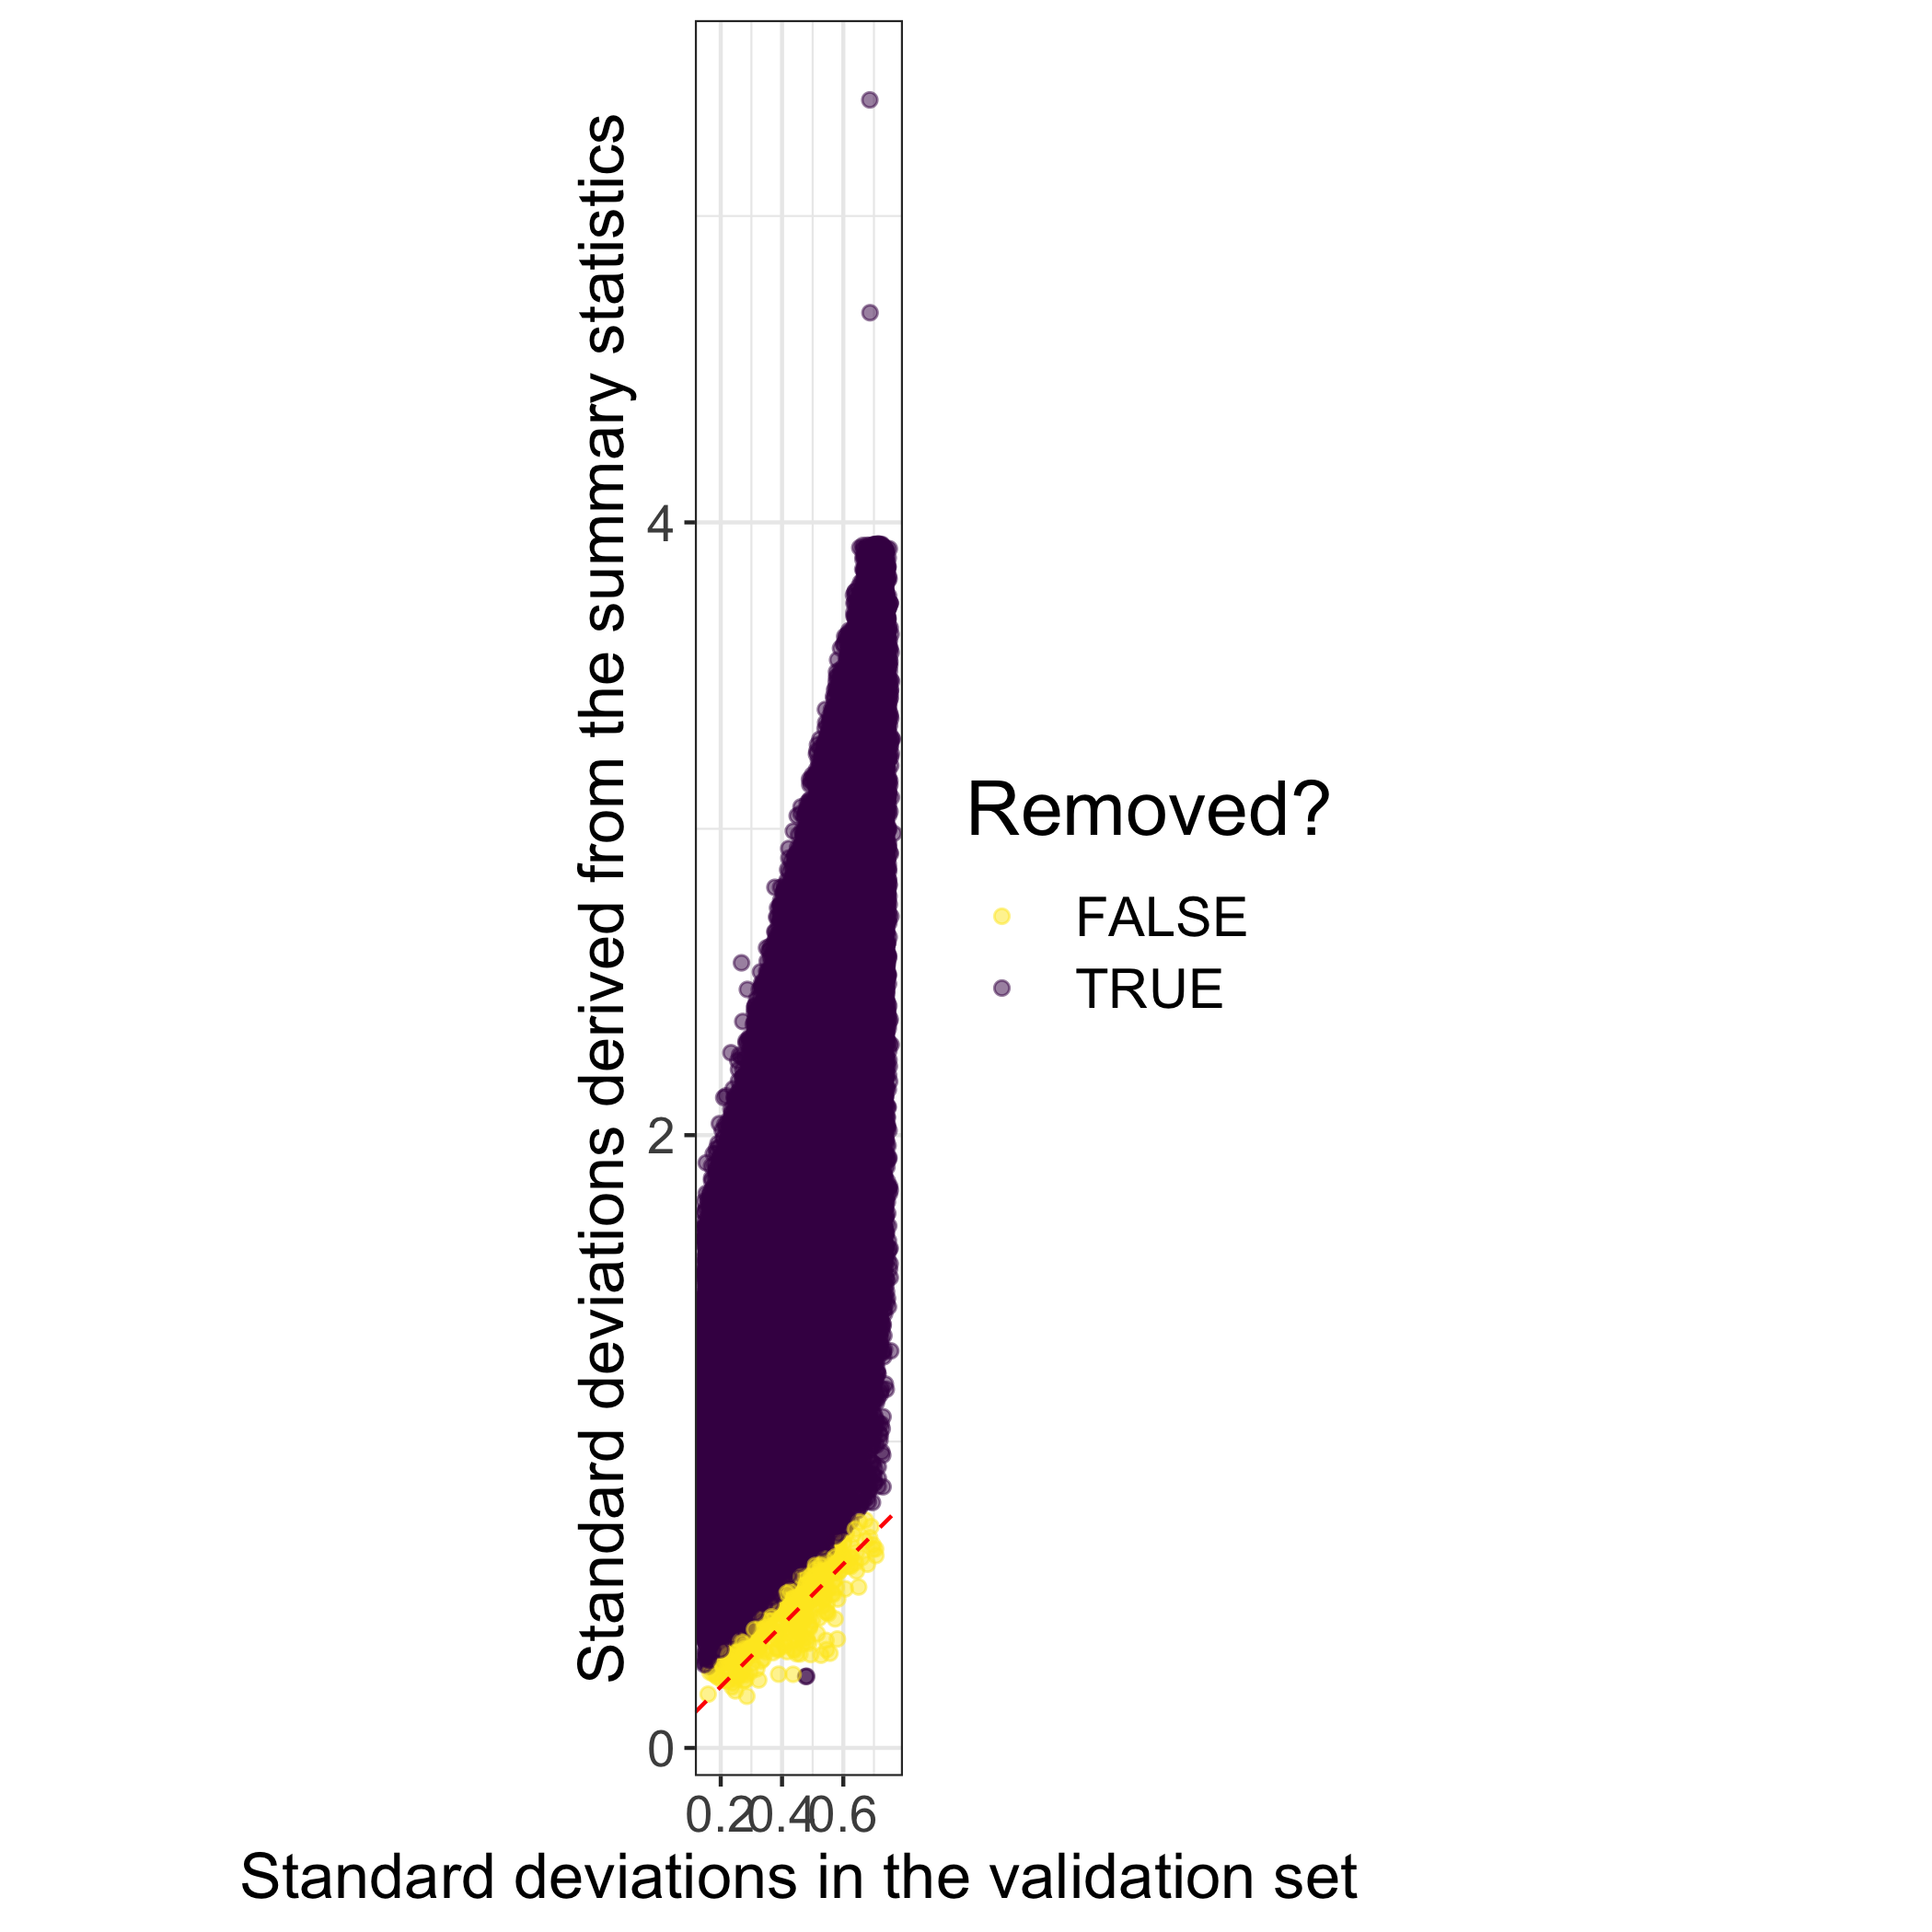

>>> res-data/plots/QcPlot.png:

bash: res-data/plots/QcPlot.png: Permission denied


In [1]:
%preview res-data/plots/QcPlot.png

* Convergence of Z-score for gird model for different $h^2$ and $p$

> res-data/plots/GridPlot.png (250.4 KiB):

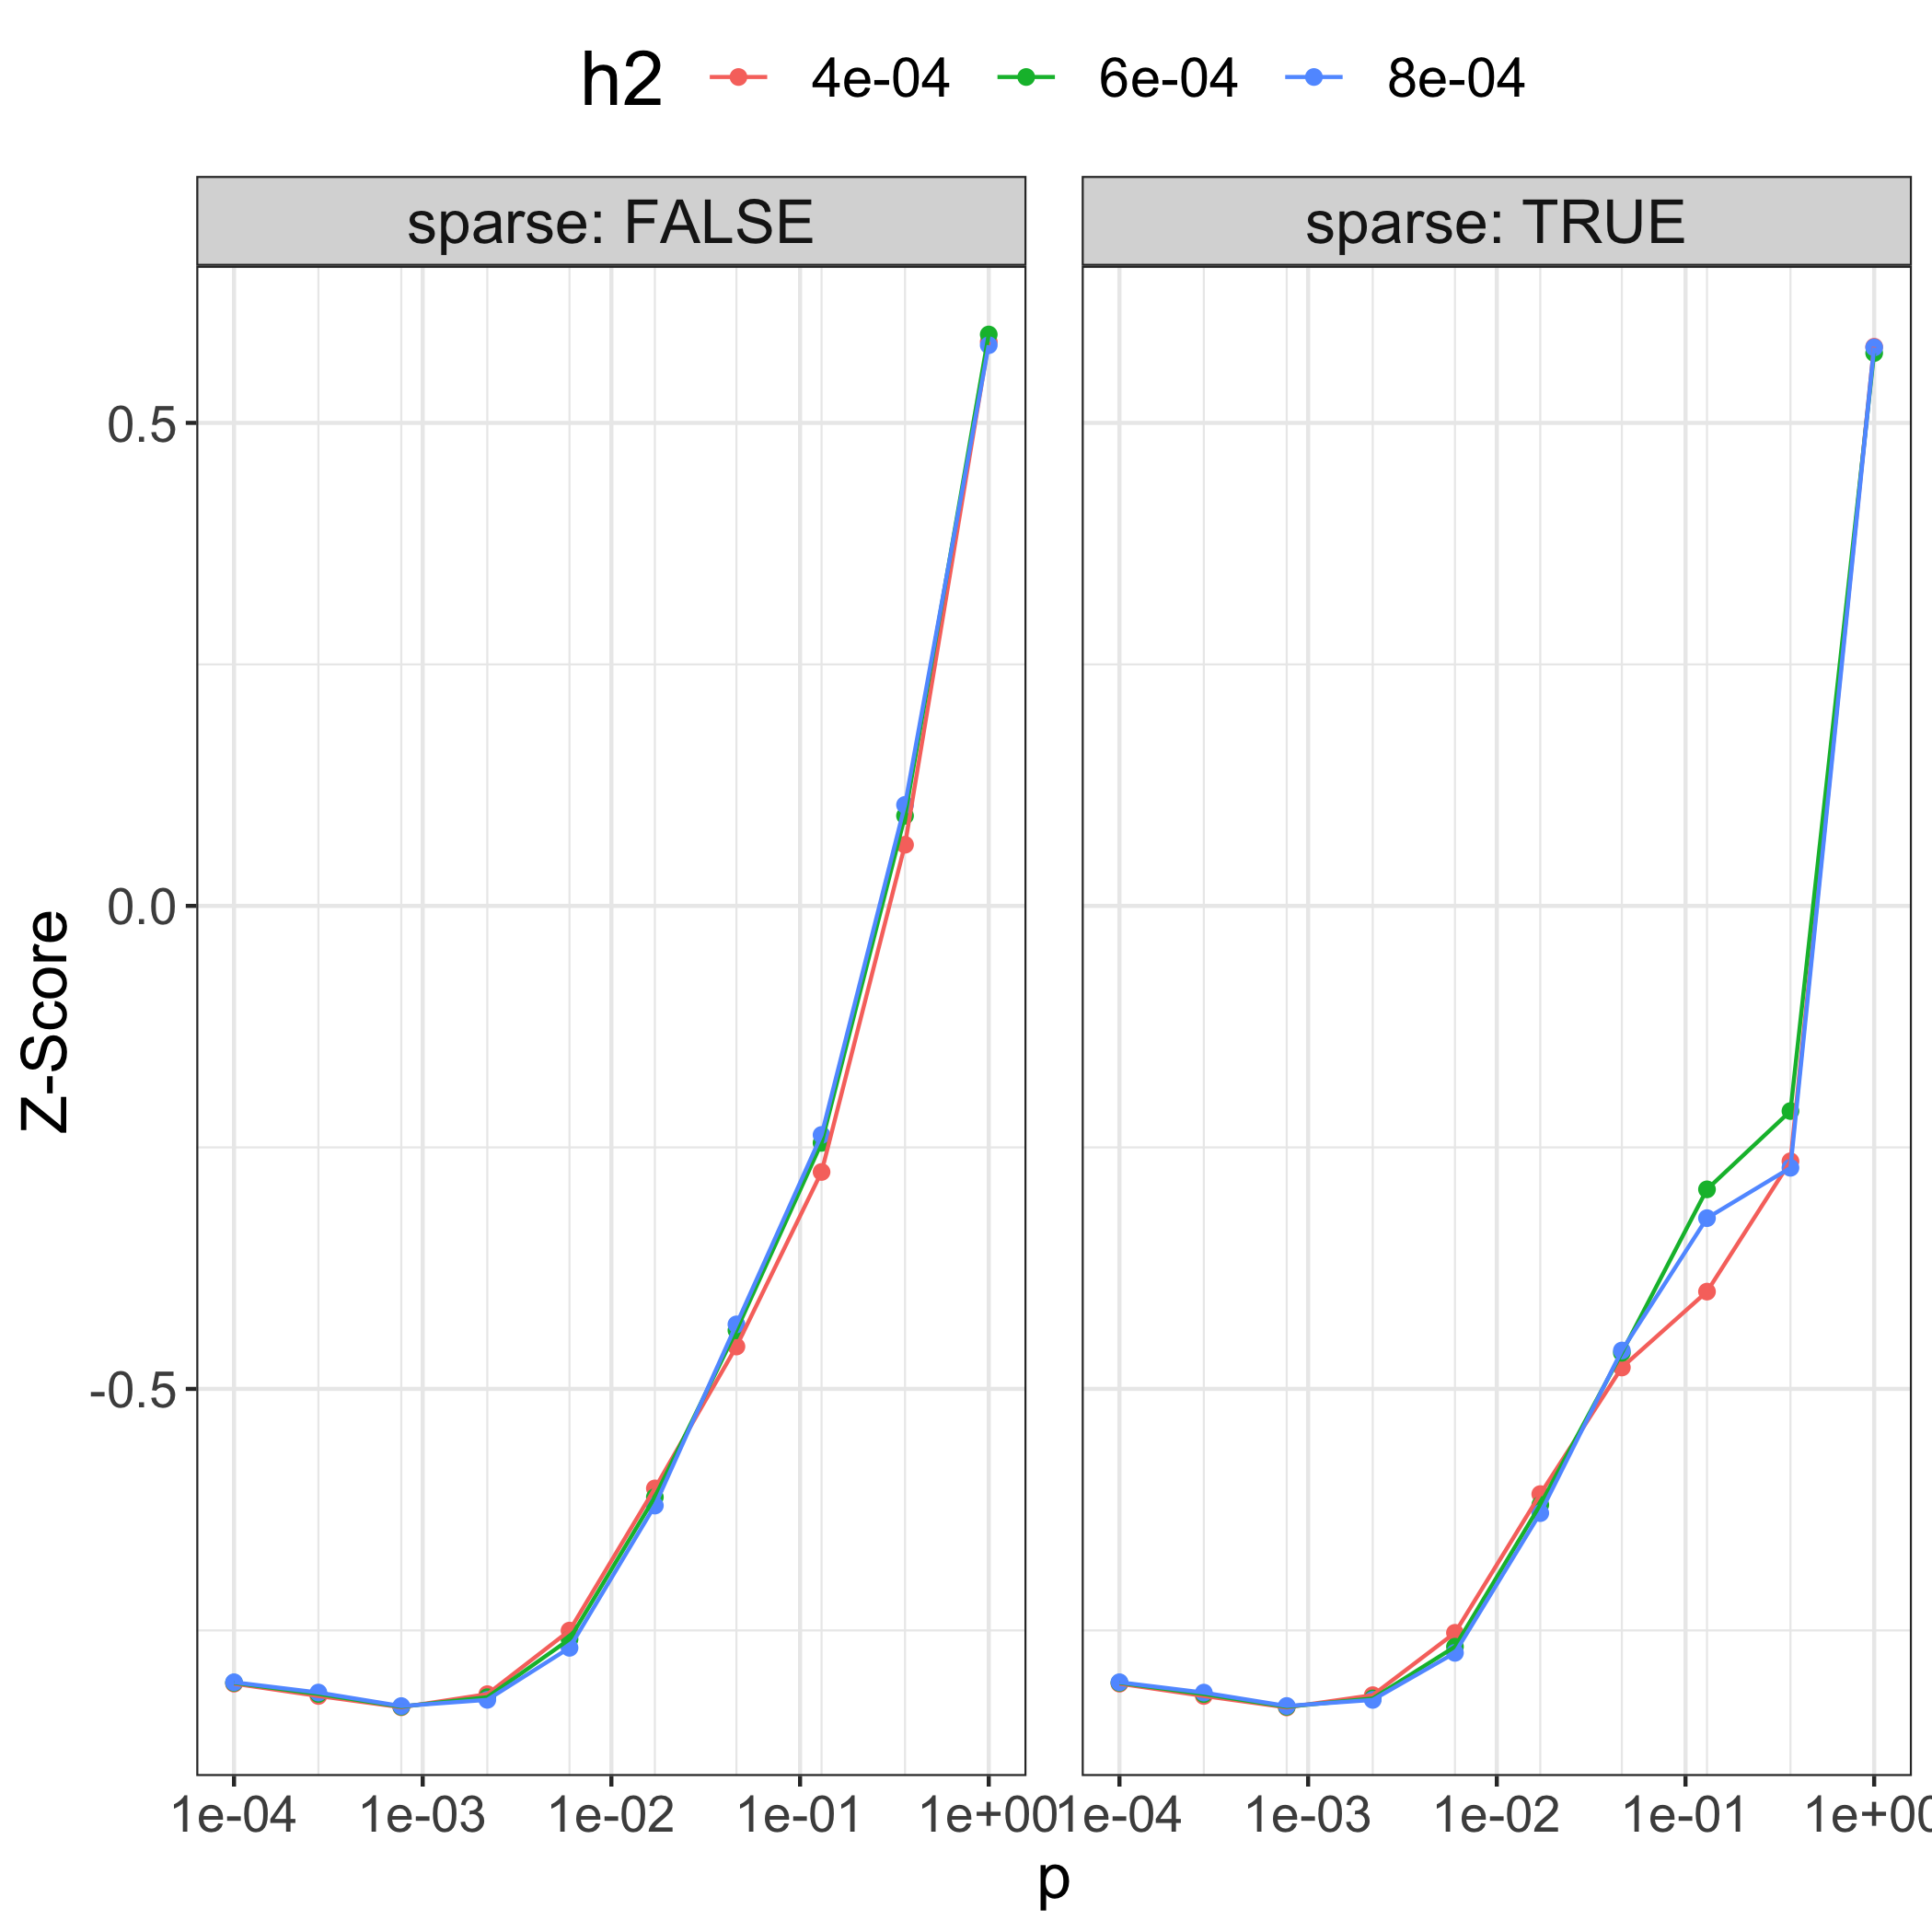

>>> res-data/plots/GridPlot.png:

bash: res-data/plots/GridPlot.png: Permission denied


In [2]:
%preview res-data/plots/GridPlot.png

* Convergence of $h^2$ and $p$ in auto model

> res-data/plots/AutoPlot.png (562.7 KiB):

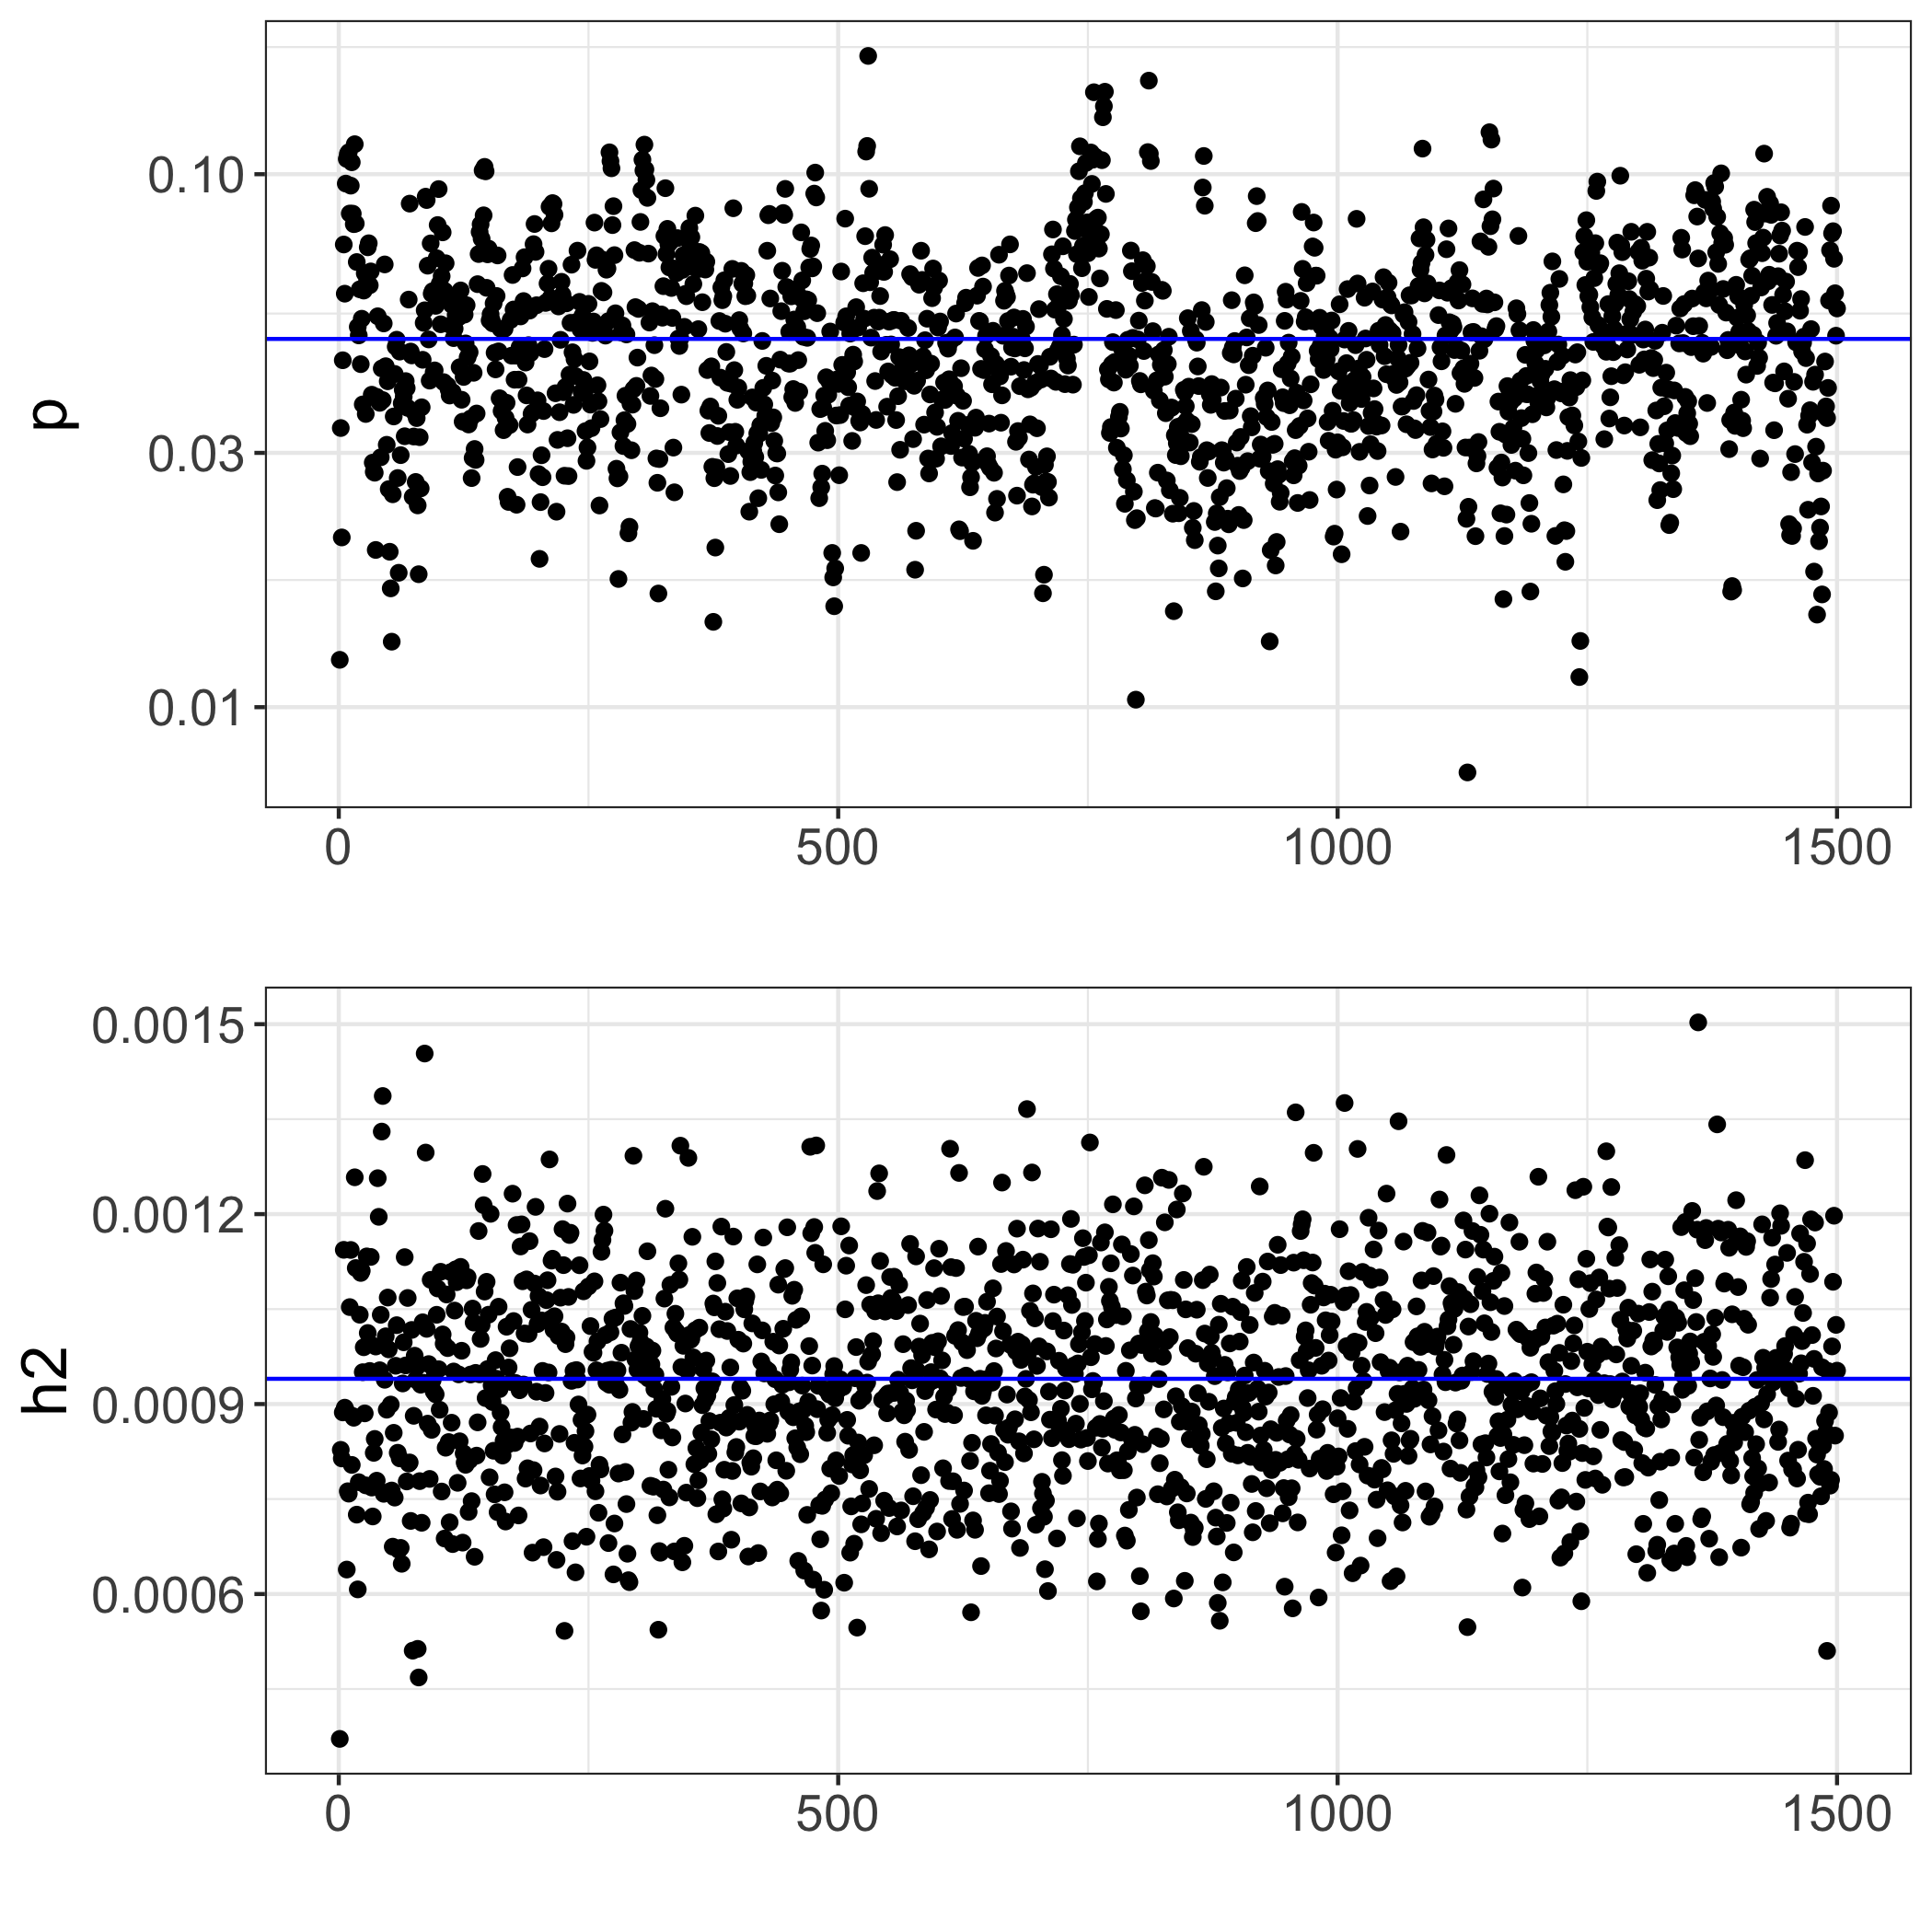

>>> res-data/plots/AutoPlot.png:

bash: res-data/plots/AutoPlot.png: Permission denied


In [3]:
%preview res-data/plots/AutoPlot.png

* Model summary for inf model

In [7]:
open res-data/summary/InfSummary.pdf

: 1